In [ ]:
link_dataset_microsoft = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
link_dataset_google = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [ ]:
import requests
URL = link_dataset_microsoft
response = requests.get(URL)
dataset_file_name = 'dataset.zip'
open(dataset_file_name, "wb").write(response.content)

824887076

In [ ]:
import os

In [ ]:
os.getcwd()

'/content'

In [ ]:
ls

dataset.zip  sample_data/


In [ ]:
import zipfile
dest_folder = 'dataset'
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall(dest_folder)

In [ ]:
from PIL import Image

cats_folder = './dataset/PetImages/Cat/'
dogs_folder = './dataset/PetImages/Dog/'

def get_images_stats(dir):
    resolutions = {}
    imgs_file_names = os.listdir(dir)
    file_names = []
    corrupted_file_names = []
    for img in imgs_file_names:
        try:
            composed_path = os.path.join(dir, img)
            img_size = Image.open(composed_path).size
            if img_size not in resolutions: resolutions[img_size] = 0
            resolutions[img_size] += 1
            file_names.append(composed_path)
        except:
            corrupted_file_names.append(composed_path)
    return file_names, resolutions, corrupted_file_names

cats_imgs, cats_resolutions, corrupted_cat_imgs = get_images_stats(cats_folder)
dogs_imgs, dogs_resolutions, corrupted_dog_imgs = get_images_stats(dogs_folder)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
# verifying classes balance and corrupted files
print(len(cats_imgs))
print(len(dogs_imgs))
print(len(corrupted_cat_imgs), corrupted_cat_imgs)
print(len(corrupted_dog_imgs), corrupted_dog_imgs)

12499
12499
2 ['./dataset/PetImages/Cat/666.jpg', './dataset/PetImages/Cat/Thumbs.db']
2 ['./dataset/PetImages/Dog/11702.jpg', './dataset/PetImages/Dog/Thumbs.db']


In [ ]:
# average resolution
total_resolutions = {**cats_resolutions, **dogs_resolutions}
average_resolution = {'width': 0, 'height': 0}

counter = 0
for res in total_resolutions:
  count = total_resolutions[res]
  counter += count
  average_resolution['width'] += res[0]*count
  average_resolution['height'] += res[1]*count

average_resolution['width'] //= counter
average_resolution['height'] //= counter

reshape_target_size = (average_resolution['width'], average_resolution['height'])

# forcing target size
reshape_target_size = (128, 128)
reshape_target_size

(128, 128)

In [ ]:
# remove corrupted images
corrupted = corrupted_cat_imgs + corrupted_dog_imgs
for cor_img in corrupted:
  if cor_img[-3:] == 'jpg': os.remove(cor_img)

In [ ]:
# create train and test sets
train_cats_folder = './dataset/train/cats/'
train_dogs_folder = './dataset/train/dogs/'
test_cats_folder = './dataset/test/cats/'
test_dogs_folder = './dataset/test/dogs/'

# train e test folders creation
os.makedirs(train_cats_folder, exist_ok=True)
os.makedirs(train_dogs_folder, exist_ok=True)
os.makedirs(test_cats_folder, exist_ok=True)
os.makedirs(test_dogs_folder, exist_ok=True)

In [ ]:
os.getcwd()

'/content'

In [ ]:
cats_imgs[0]

'./dataset/PetImages/Cat/12003.jpg'

In [ ]:
print(len(os.listdir('./dataset/train/cats/')))
print(len(os.listdir('./dataset/PetImages/Cat/')))
print(len(os.listdir('./dataset/test/cats/')))

0
12500
0


In [ ]:
import shutil
import random
from PIL import Image
from tqdm import tqdm

train_percentage = 0.85

def train_test_folders_split(imgs_paths, train_split, target_resolution, train_dir_path, test_dir_path):
    num_train_imgs = int(len(imgs_paths) * train_split)
    random.seed(42) # for reproducibility purposes
    random.shuffle(imgs_paths)
    fails = []
    for i, img_path in tqdm(enumerate(imgs_paths), total=len(imgs_paths), desc=f"{imgs_paths[0].split('/')[-2]} splitting"):
        try:
            img_reshaped = Image.open(img_path).resize(target_resolution)
            # print(img_reshaped.size)
            if i < num_train_imgs:
              img_reshaped.save(f"{train_dir_path}{img_path.split('/')[-1]}")
            else:
              img_reshaped.save(f"{test_dir_path}{img_path.split('/')[-1]}")
        except: fails.append(img_path)
        # if i == int(len(imgs_paths) * 0.01): break


cats_fails = train_test_folders_split(cats_imgs, train_percentage, reshape_target_size, train_cats_folder, test_cats_folder)
dogs_fails = train_test_folders_split(dogs_imgs, train_percentage, reshape_target_size, train_dogs_folder, test_dogs_folder)

print(cats_fails)
print(dogs_fails)

Dog splitting: 100%|██████████| 12499/12499 [00:40<00:00, 304.97it/s]

None
None


In [ ]:
print(len(os.listdir('./dataset/train/cats/')))
print(len(os.listdir('./dataset/PetImages/Cat/')))
print(len(os.listdir('./dataset/test/cats/')))

10600
12500
1873


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# Defining desired tranformations
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train/',
    target_size = reshape_target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'dataset/train/',
    target_size = reshape_target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 18022 images belonging to 2 classes.
Found 3180 images belonging to 2 classes.


In [ ]:
batch_images, batch_labels = train_generator.next()
batch_images.shape

(64, 128, 128, 3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = batch_images[0].shape

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 75

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/75
281/281 [==============================] - 119s 375ms/step - loss: 0.7206 - accuracy: 0.5104 - val_loss: 0.6816 - val_accuracy: 0.5631
Epoch 2/75
281/281 [==============================] - 106s 376ms/step - loss: 0.6788 - accuracy: 0.5688 - val_loss: 0.6546 - val_accuracy: 0.5912
Epoch 3/75
281/281 [==============================] - 106s 377ms/step - loss: 0.6583 - accuracy: 0.6096 - val_loss: 0.6321 - val_accuracy: 0.6626
Epoch 4/75
281/281 [==============================] - 106s 376ms/step - loss: 0.6204 - accuracy: 0.6624 - val_loss: 0.5877 - val_accuracy: 0.6920
Epoch 5/75
281/281 [==============================] - 100s 355ms/step - loss: 0.5890 - accuracy: 0.6868 - val_loss: 0.5477 - val_accuracy: 0.7254
Epoch 6/75
281/281 [==============================] - 99s 351ms/step - loss: 0.5520 - accuracy: 0.7157 - val_loss: 0.5122 - val_accuracy: 0.7474
Epoch 7/75
281/281 [==============================] - 98s 350ms/step - loss: 0.5303 - accuracy: 0.7371 - val_loss: 0.4803 - v

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


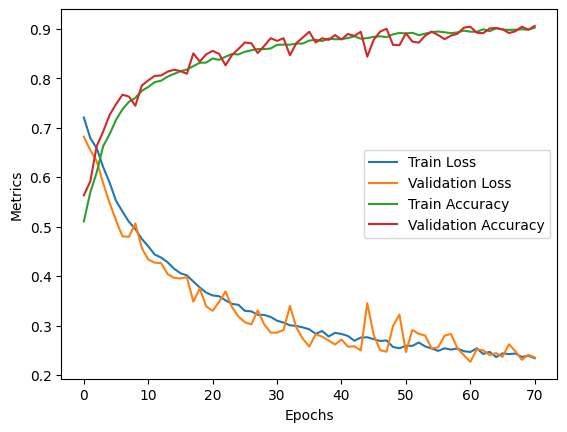

In [ ]:
print(history.history.keys())

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(history.history)
df.to_csv('history.csv', index=False)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test/',
    target_size = reshape_target_size,
    batch_size=32,
    class_mode='binary',
)

Found 3737 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

117/117 [==============================] - 3s 23ms/step - loss: 0.1862 - accuracy: 0.9227
Test Accuracy: 0.9226652383804321


In [ ]:
total_predictions = []
total_labels = []

i = 0
for i, batch in enumerate(test_generator):
  images, labels = batch
  preds = model.predict(images, verbose=0)
  preds = np.where(preds<0.5,0,1)
  preds = list(map(lambda x: x[0], preds))
  total_predictions = total_predictions + preds
  total_labels = total_labels + list(labels)
  if i == len(test_generator)-1: break

# print(total_predictions)
# print(total_labels)

accuracy = accuracy_score(total_labels, total_predictions)
print("Accuracy:", accuracy)

precision = precision_score(total_labels, total_predictions)
print("Precision:", precision)

recall = recall_score(total_labels, total_predictions)
print("Recall:", recall)

f1 = f1_score(total_labels, total_predictions)
print("F1-score:", f1)

conf_matrix = confusion_matrix(total_labels, total_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9248059941129249
Precision: 0.9255663430420712
Recall: 0.9230769230769231
F1-score: 0.9243199569081605
Confusion Matrix:
[[1740  138]
 [ 143 1716]]


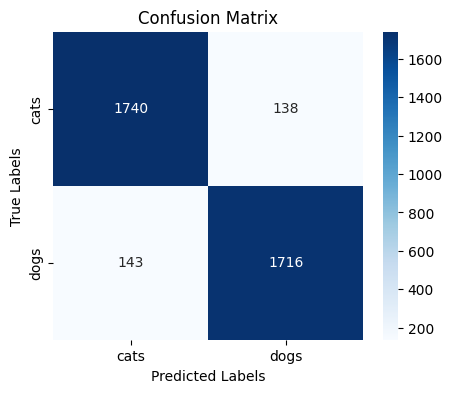

In [ ]:
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('classifier.keras')

In [ ]:
import pickle

with open('cats_train.pickle', 'wb') as file: pickle.dump(os.listdir('./dataset/train/cats/'), file)
with open('cats_test.pickle', 'wb') as file: pickle.dump(os.listdir('./dataset/test/cats/'), file)
with open('dogs_train.pickle', 'wb') as file: pickle.dump(os.listdir('./dataset/train/dogs/'), file)
with open('dogs_test.pickle', 'wb') as file: pickle.dump(os.listdir('./dataset/test/dogs/'), file)

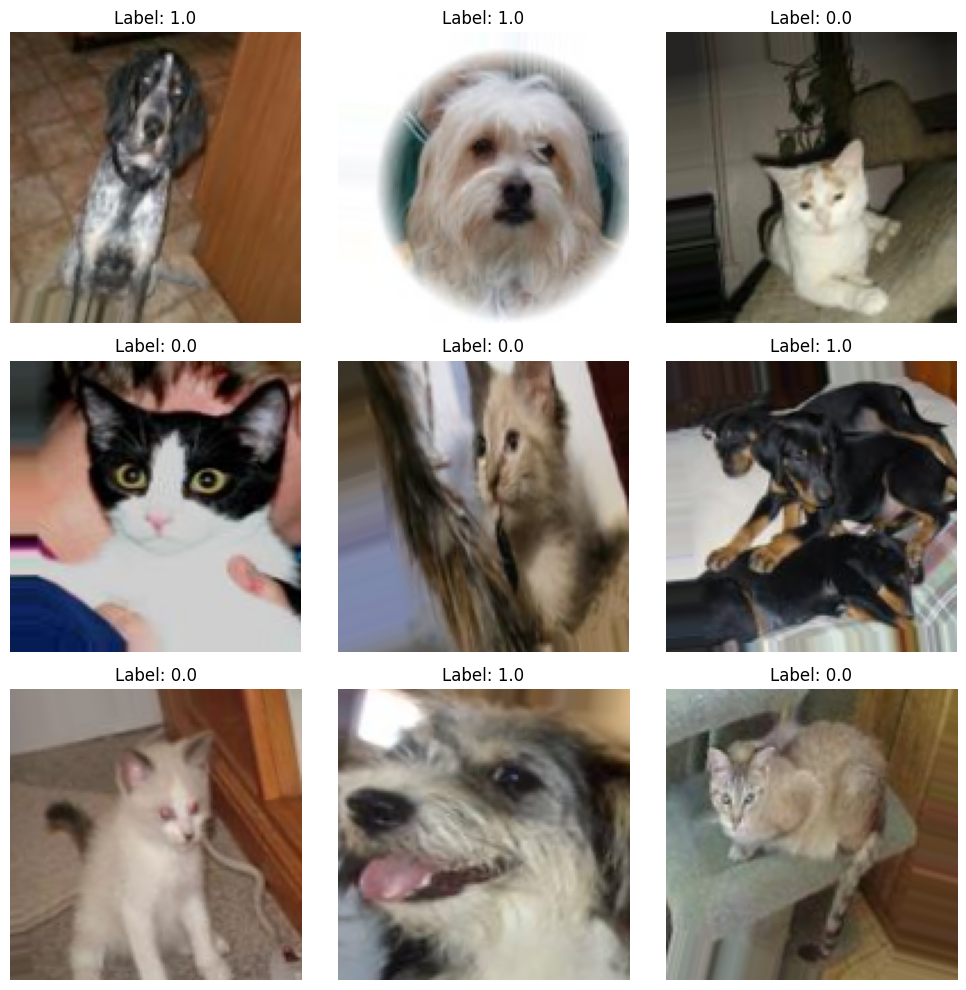

In [ ]:
import matplotlib.pyplot as plt

batch_images, batch_labels = validation_generator.next()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"Label: {batch_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# continue training

from tensorflow.keras.models import load_model

model_two = load_model('classifier.keras')

history_two = model_two.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)